# XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of the gradient boosting algorithm. It is widely used for supervised learning tasks such as classification and regression. XGBoost builds an ensemble of decision trees in a sequential manner, where each tree attempts to correct the errors of the previous ones. Key features include:

- **Gradient Boosting**: Optimizes a loss function by adding weak learners (decision trees) iteratively.
- **Regularization**: Includes L1 and L2 regularization to prevent overfitting.
- **Parallelization**: Supports parallel computation to speed up training.
- **Handling Missing Values**: Automatically learns the best way to handle missing data.
- **Custom Objective Functions**: Allows users to define their own loss functions.

In this notebook, XGBoost is used to classify images into different categories based on extracted features. You can check the [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for more details.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# imports and path setup
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import tqdm
from joblib import Parallel, delayed, parallel_backend
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from userkits.features import *
from userkits.utils import *
from sklearn.utils.class_weight import compute_sample_weight



## Load and Shuffle Data

In [83]:
HALF_SIZE = False

In [84]:
# load data from train and eval directories
# set half=True to resize images to half to reduce memory usage
X, y = load_train_data(data_dir='../train_data/train_data', half=HALF_SIZE)
X, y = shuffle(X, y, random_state=42)

## Transform Data and Add Features

The steps to include new features are detailed in (the file). You can find the definitions of currently included features there.

In [9]:
# def process_image(img):
#     feats = []
#     # add feature functions here
#     feats.extend(color_histogram(img))
#     feats.extend(lbp_texture_features(img))
#     feats.extend(find_mean(img))
#     feats.extend(find_stddev(img))

#     feats.append(green_pixel_ratio(img))
#     feats.append(edge_density(img))
#     feats.append(extra_features(img))

#     return feats

# def extract_features(images):
#     feats = []
#     for img in X:
#         f = feature_check(img)
#         feats.append(f)
#     # This guarantees .shape is available and is (n_samples, n_features)
#     return np.vstack(feats)


In [85]:
def extract_features(images):
    features_list = []
    
    def process_image(img):
        # --- START FIX ---
        # Resize all images to a consistent size BEFORE feature extraction
        # This ensures HOG, LBP, etc., all produce vectors of the same length.
        FIXED_SIZE = (256, 256)  # You could also use (128, 128)
        img = cv2.resize(img, FIXED_SIZE, interpolation=cv2.INTER_AREA)
        # --- END FIX ---
        
        # We need to convert the image format once for different libraries
        # The input 'img' from load_train_data is already BGR numpy array
        
        # --- Features from feature_check ---
        # (You can just call feature_check(img) or be more explicit)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

        hist_3d = cv2.calcHist([img_rgb], [0,1,2], None, [8,8,8], [0,256,0,256,0,256]).flatten()
        
        lbp  = local_binary_pattern(gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8+3), range=(0, 8+2))
        
        edges = cv2.Canny(gray, 100, 200)
        edge_density_val = (edges > 0).mean()
        brightness_val = hsv[...,2].mean()
        saturation_val = hsv[...,1].mean()

        # --- Your other defined features ---
        mean_rgb = find_mean(img_rgb)       # (3 features)
        std_rgb = find_stddev(img_rgb)       # (3 features)
        entropy_val = shannon_entropy(img)     # (1 feature, input is BGR)
        green_ratio = green_pixel_ratio(img)   # (1 feature, input is BGR)
        #hog_feats = hog_features(img)          # (Now a fixed size!)
        haralick_feats = haralick_texture_features(img) # (13 features, input is BGR)
        #gabor_feats = gabor_features(img)      # (24 features, input is BGR)

        # Combine them all into one long vector
        all_features = np.hstack([
            hist_3d,
            lbp_hist,
            [edge_density_val, brightness_val, saturation_val],
            mean_rgb,
            std_rgb,
            [entropy_val, green_ratio],
            haralick_feats,
            #gabor_feats
        ])
        return all_features.astype(np.float32)

    features_list = Parallel(n_jobs=-1)(delayed(process_image)(img) for img in tqdm.tqdm(images, desc="Extracting features"))
    return np.vstack(features_list)

In [86]:
X_features = extract_features(X)
X_features.shape





















































































































































































































































































































































































Extracting features: 100%|██████████| 1483/1483 [00:26<00:00, 56.01it/s]


(1483, 546)

In [65]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Common hyperparameters
- `learning_rate`: Controls the step size at each iteration while moving toward a minimum of the loss function. Default is 0.1.
- `max_depth`: Maximum depth of a tree. Increasing this value makes the model more complex and likely to overfit. Default is 5.
- `n_estimators`: Number of gradient boosted trees. Equivalent to the number of boosting rounds. Default is 100.
- `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child. Used to control overfitting. Default is 1.
- `subsample`: Fraction of samples used for fitting the individual base learners. Default is 1.0.
- `colsample_bytree`: Fraction of features used for fitting individual trees. Default is 1.0.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node. Default is 0.

Train Accuracy: 1.0
Test Accuracy: 0.898989898989899
Overall Accuracy (test): 0.8990

Per-biome results:


,precision,recall,f1-score,support
bamboo_jungle,1.000000,0.818182,0.900000,11.00000
beach,0.916667,1.000000,0.956522,11.00000
birch_forest,0.882353,0.937500,0.909091,16.00000
dark_forest,0.875000,1.000000,0.933333,7.00000
desert,1.000000,0.909091,0.952381,11.00000
forest,1.000000,1.000000,1.000000,10.00000
gravelly_mountains+,0.857143,0.923077,0.888889,13.00000
jungle,0.714286,0.833333,0.769231,6.00000
jungle_edge,0.692308,0.818182,0.750000,11.00000
jungle_hills,0.777778,1.000000,0.875000,7.00000


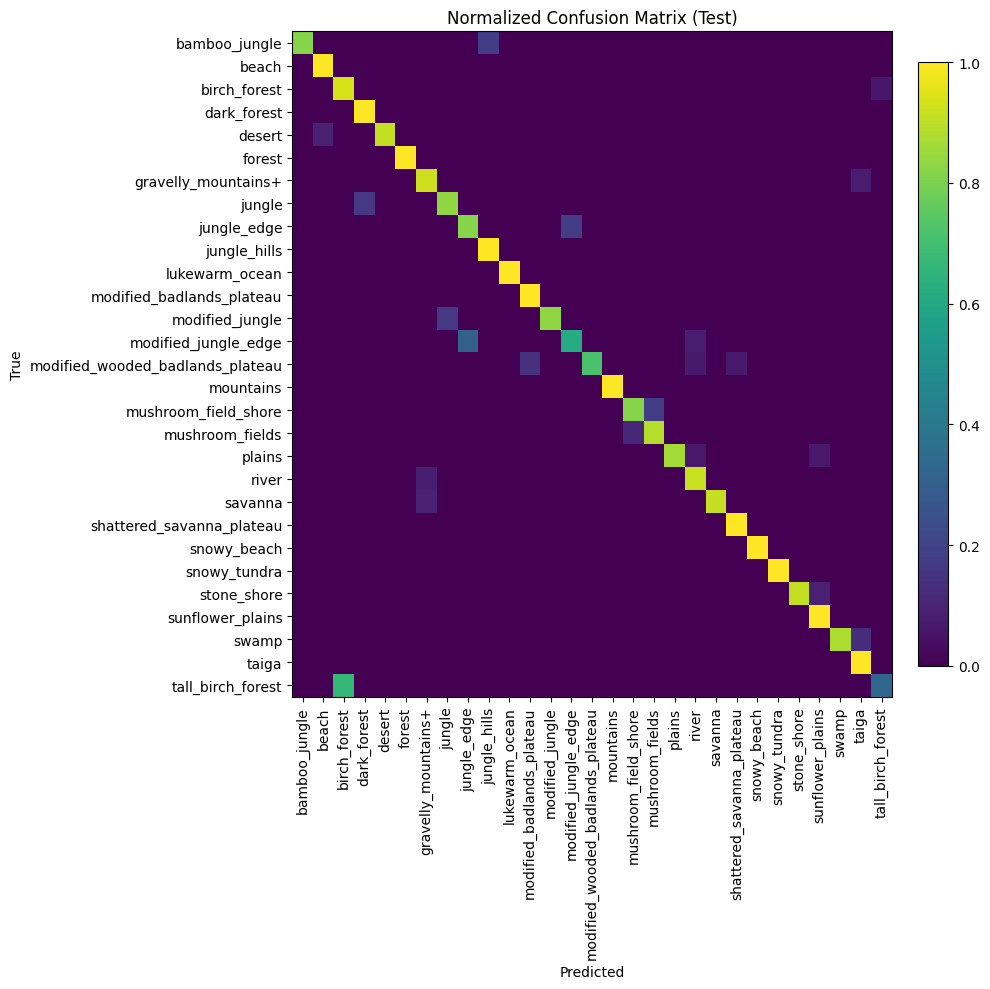

In [89]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2)  # you can change test_size
clf = XGBClassifier(
    n_estimators=500,       # Keep this high, early stopping will find the best value
    max_depth=5,            # You can still tune this
    learning_rate=0.08,
    subsample=0.8,          # Added
    colsample_bytree=0.8,   # Added
    gamma=0.1,              # Added
)
clf.fit(X_train, y_train)
print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

# === Biome classification evaluation (drop-in cell) ===

# 1) Predict on your held-out test split
y_pred = clf.predict(X_test)

# 2) Overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy (test): {acc:.4f}")

# 3) Per-biome metrics (precision/recall/F1/support)
# Map integer labels back to biome names
try:
    classes = label_encoder.classes_
    target_names = list(classes)
except Exception:
    # Fallback if no encoder is present (rare given your code)
    target_names = [str(i) for i in sorted(np.unique(y_test))]

report_dict = classification_report(
    y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0
)
per_biome = (
    pd.DataFrame(report_dict)
      .transpose()
      .loc[target_names + ["accuracy", "macro avg", "weighted avg"]]
)

print("\nPer-biome results:")
display(per_biome)

# 4) Confusion matrix (normalized by true class)
cm = confusion_matrix(y_test, y_pred, labels=range(len(target_names)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_norm, aspect="auto")
ax.set_xticks(range(len(target_names)))
ax.set_yticks(range(len(target_names)))
ax.set_xticklabels(target_names, rotation=90)
ax.set_yticklabels(target_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Normalized Confusion Matrix (Test)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## Evaluate

In [69]:
# load eval data
# set half=True to resize images to half to reduce memory usage
X_eval, file_ids = load_eval_data("../eval_data/eval_data", half=HALF_SIZE) 

















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Loading eval data: 100%|██████████| 1486/1486 [00:28<00:

In [70]:
X_eval_features = extract_features(X_eval)
eval_predictions = clf.predict(X_eval_features)
print(eval_predictions[:5])

































































































Extracting features: 100%|██████████| 1486/1486 [00:05<00:00, 253.64it/s]


[19 20 24 14 14]


In [71]:
try:
    preds = label_encoder.inverse_transform(eval_predictions)
except Exception:
    preds = eval_predictions

save_predictions(preds, file_ids, output_file='../output/xgboost_predictions.csv')

Saved ../output/xgboost_predictions.csv
